In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## 1. Imports and Model Loading

In [1]:
import os
import uuid
import imageio
import numpy as np
from IPython.display import Image as ImageDisplay
import torch

from inference import Inference, ready_gaussian_for_video_rendering, load_image, load_masks, display_image, make_scene, render_video, interactive_visualizer

/venv/sam3d-objects/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Warp 1.11.0 initialized:
   CUDA Toolkit 12.9, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX A6000" (47 GiB, sm_86, mempool enabled)
   Kernel cache:
     /root/.cache/warp/1.11.0
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2026-01-06 08:04:32.833 | INFO     | sam3d_objects.pipeline.inference_pipeline:set_attention_backend:17 - GPU name is NVIDIA RTX A6000
2026-01-06 08:04:33.929 | INFO     | sam3d_objects.model.backbone.tdfy_dit.modules.sparse:__from_env:39 - [SPARSE] Backend: spconv, Attention: sdpa
2026-01-06 08:04:39.714 | INFO     | sam3d_objects.model.backbone.tdfy_dit.modules.attention:__from_env:30 - [ATTENTION] Using backend: sdpa


[SPARSE][CONV] spconv algo: auto


2026-01-06 08:04:40.184 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
2026-01-06 08:04:40.185 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 


In [2]:
PATH = os.getcwd()
TAG = "hf"
config_path = f"{PATH}/../checkpoints/{TAG}/pipeline.yaml"
inference = Inference(config_path, compile=False)

2026-01-06 08:04:40.471 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 


/venv/sam3d-objects/lib/python3.11/site-packages/moge/model/v1.py:171: UserWarning: The following deprecated/invalid arguments are ignored: {'output_mask': True, 'split_head': True}
  warnings.warn(f"The following deprecated/invalid arguments are ignored: {deprecated_kwargs}")
2026-01-06 08:04:48.662 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
2026-01-06 08:04:48.665 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:100 - self.device: cuda
2026-01-06 08:04:48.666 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:101 - CUDA_VISIBLE_DEVICES: None
2026-01-06 08:04:48.667 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:102 - Actually using GPU: 0
2026-01-06 08:04:48.668 | INFO     | sam3d_objects.pipeline.inference_pipeline:init_pose_decoder:297 - Using pose decoder: ScaleShiftInvariant
2026-01-06 08:04:48.668 | INFO     | sam3d_objects.pipeline.inference_p

## 2. Load input image to lift to 3D (multiple objects)

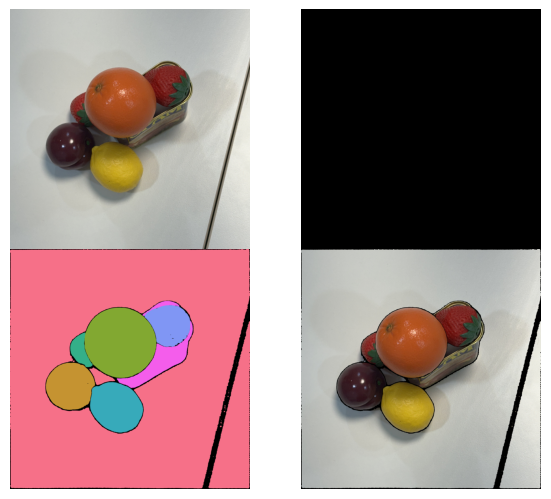

In [3]:
IMAGE_PATH = f"{PATH}/images/segment1/image.jpg"
IMAGE_NAME = os.path.basename(os.path.dirname(IMAGE_PATH))

image = load_image(IMAGE_PATH)
masks = load_masks(os.path.dirname(IMAGE_PATH), extension=".png")
display_image(image, masks)

## 3. Generate Gaussian Splats

In [4]:
# masks를 제외한 곳에서 1인 bg_mask (H, W, 1)
bg_mask = 1 - np.clip(np.sum(masks, axis=0, keepdims=True), 0, 1) # (1, H, W)
bg_mask = np.transpose(bg_mask, (1, 2, 0))  # (H, W, 1)

plane = inference._pipeline.run(
    image,
    bg_mask,
    42,
    stage1_only=False,
    with_mesh_postprocess=False,
    with_texture_baking=False,
    with_layout_postprocess=True,
    use_vertex_color=True,
    stage1_inference_steps=None,
    pointmap=None,
    estimate_plane=True
)

2026-01-06 08:05:27.041 | INFO     | sam3d_objects.pipeline.inference_pipeline:merge_image_and_mask:584 - Replacing alpha channel with the provided mask


2026-01-06 08:05:28.076 | INFO     | sam3d_objects.pipeline.inference_pipeline_pointmap:estimate_plane2:541 - Plane estimation: 20919 points, 1.000 area coverage
2026-01-06 08:05:29.478 | INFO     | sam3d_objects.pipeline.inference_pipeline_pointmap:estimate_plane2:673 - Selected plane k=0 score=2.996 inliers=18151 support=0.868 flat=0.997 low=0.950
2026-01-06 08:05:29.481 | INFO     | sam3d_objects.pipeline.inference_utils:o3d_plane_estimation:666 - Plane equation: -0.12x + -0.14y + 0.98z + -1.80 = 0
2026-01-06 08:05:29.484 | INFO     | sam3d_objects.pipeline.inference_utils:o3d_plane_estimation:683 - Flying point removal: 18148 -> 17240 points (z_range: 0.51m, thresh: 0.95)
2026-01-06 08:05:29.485 | INFO     | sam3d_objects.pipeline.inference_utils:o3d_plane_estimation:684 - Clean points Z range: [1.603, 2.014]
2026-01-06 08:05:29.486 | INFO     | sam3d_objects.pipeline.inference_utils:o3d_plane_estimation:707 - Plane basis vectors - v1: [-0.000, 0.990, 0.140], v2: [-0.993, 0.016, -0

In [5]:
outputs = [inference(image, mask, seed=42) for mask in masks[1:]]

2026-01-06 08:05:31.399 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_sparse_structure:664 - Sampling sparse structure: inference_steps=25, strength=7, interval=[0, 500], rescale_t=3, cfg_strength_pm=0.0
2026-01-06 08:05:31.400 | INFO     | sam3d_objects.pipeline.inference_pipeline:get_condition_input:633 - Running condition embedder ...
2026-01-06 08:05:31.609 | INFO     | sam3d_objects.pipeline.inference_pipeline:get_condition_input:637 - Condition embedder finishes!
2026-01-06 08:05:38.070 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_sparse_structure:714 - Downsampled coords from 18717 to 18717
2026-01-06 08:05:38.111 | INFO     | sam3d_objects.pipeline.inference_pipeline_pointmap:run:369 - Rescaling scale by 1 after downsampling
2026-01-06 08:05:38.113 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_slat:744 - Sampling sparse latent: inference_steps=25, strength=1, interval=[0, 500], rescale_t=1
2026-01-06 08:05:38.114 | INFO     | sam

## 3.5 Align with plane

In [6]:
import numpy as np
import trimesh
from pytorch3d.transforms import quaternion_multiply, quaternion_invert, quaternion_to_matrix, matrix_to_quaternion

def flatten_plane_mesh_to_xy_pytorch3d_quat(
    mesh: trimesh.Trimesh,
    eps: float = 1e-12,
):
    """
    Returns a rigid transform that flattens the planar mesh onto the XY plane (z=0),
    using PyTorch3D quaternion convention.

    PyTorch3D quaternion convention:
      q = (w, x, y, z)  (scalar-first, Hamilton)

    Transform convention (matches PyTorch3D point transform style):
      p' = p @ R.T + t
    where R = quaternion_to_matrix(q) in PyTorch3D.

    Returns:
      mesh_xy : trimesh.Trimesh     transformed mesh
      q_p3d   : np.ndarray (4,)     quaternion (w, x, y, z)
      t       : np.ndarray (3,)     translation
    """

    V = np.asarray(mesh.vertices, dtype=np.float64)
    if V.shape[0] < 3:
        raise ValueError("mesh has too few vertices to define a plane")

    # 1) Robust normal from 3 non-collinear vertices
    tri_candidates = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
    n = None
    for i, j, k in tri_candidates:
        p0, p1, p2 = V[i], V[j], V[k]
        nn = np.cross(p1 - p0, p2 - p0)
        nn_norm = np.linalg.norm(nn)
        if nn_norm > eps:
            n = nn / nn_norm
            break
    if n is None:
        raise ValueError("degenerate plane: cannot compute a stable normal")

    # For consistent output, force normal to point roughly toward +Z
    if n[2] < 0:
        n = -n

    # 2) Rotation matrix R that aligns n -> +Z (Rodrigues)
    k = np.array([0.0, 0.0, 1.0], dtype=np.float64)
    v = np.cross(n, k)
    s = np.linalg.norm(v)          # sin(theta)
    c = float(np.dot(n, k))        # cos(theta)

    if s < eps:
        if c > 0.0:
            R = np.eye(3, dtype=np.float64)
        else:
            # 180 deg rotation: pick any axis perpendicular to n
            axis = np.array([1.0, 0.0, 0.0], dtype=np.float64)
            if abs(np.dot(axis, n)) > 0.9:
                axis = np.array([0.0, 1.0, 0.0], dtype=np.float64)
            axis = axis - np.dot(axis, n) * n
            axis = axis / np.linalg.norm(axis)

            K = np.array([[0, -axis[2], axis[1]],
                          [axis[2], 0, -axis[0]],
                          [-axis[1], axis[0], 0]], dtype=np.float64)
            # Rodrigues with theta=pi: R = I + 2K^2
            R = np.eye(3, dtype=np.float64) + 2.0 * (K @ K)
    else:
        axis = v / s
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]], dtype=np.float64)
        R = np.eye(3, dtype=np.float64) + K * s + (K @ K) * (1.0 - c)

    # 3) Rotation matrix -> PyTorch3D quaternion (w, x, y, z)
    def mat_to_quat_wxyz(Rm: np.ndarray):
        tr = float(np.trace(Rm))
        if tr > 0.0:
            S = np.sqrt(tr + 1.0) * 2.0
            w = 0.25 * S
            x = (Rm[2, 1] - Rm[1, 2]) / S
            y = (Rm[0, 2] - Rm[2, 0]) / S
            z = (Rm[1, 0] - Rm[0, 1]) / S
        elif Rm[0, 0] > Rm[1, 1] and Rm[0, 0] > Rm[2, 2]:
            S = np.sqrt(1.0 + Rm[0, 0] - Rm[1, 1] - Rm[2, 2]) * 2.0
            w = (Rm[2, 1] - Rm[1, 2]) / S
            x = 0.25 * S
            y = (Rm[0, 1] + Rm[1, 0]) / S
            z = (Rm[0, 2] + Rm[2, 0]) / S
        elif Rm[1, 1] > Rm[2, 2]:
            S = np.sqrt(1.0 + Rm[1, 1] - Rm[0, 0] - Rm[2, 2]) * 2.0
            w = (Rm[0, 2] - Rm[2, 0]) / S
            x = (Rm[0, 1] + Rm[1, 0]) / S
            y = 0.25 * S
            z = (Rm[1, 2] + Rm[2, 1]) / S
        else:
            S = np.sqrt(1.0 + Rm[2, 2] - Rm[0, 0] - Rm[1, 1]) * 2.0
            w = (Rm[1, 0] - Rm[0, 1]) / S
            x = (Rm[0, 2] + Rm[2, 0]) / S
            y = (Rm[1, 2] + Rm[2, 1]) / S
            z = 0.25 * S

        q = np.array([w, x, y, z], dtype=np.float64)
        q /= np.linalg.norm(q)

        # Optional: enforce w >= 0 for a consistent representative
        if q[0] < 0:
            q = -q
        return q

    q_p3d = mat_to_quat_wxyz(R)

    # 4) Translation so the plane lies exactly on z=0
    centroid = V.mean(axis=0)
    centroid_rot = centroid @ R.T
    t0 = np.array([0.0, 0.0, -centroid_rot[2]], dtype=np.float64)

    # Fold rotate-about-centroid into single rigid transform: p' = p @ R.T + t
    t = centroid - centroid @ R.T + t0

    # 5) Apply transform to mesh
    V_xy = V @ R.T + t
    mesh_xy = trimesh.Trimesh(vertices=V_xy, faces=mesh.faces, process=False)
    if getattr(mesh, "visual", None) is not None:
        try:
            mesh_xy.visual = mesh.visual.copy()
        except Exception:
            pass

    return mesh_xy, q_p3d, t

In [7]:
plane_xy, q_p3d, _ = flatten_plane_mesh_to_xy_pytorch3d_quat(plane['glb'])
q_p3d = torch.tensor(q_p3d, dtype=torch.float32)

_R_ZUP_TO_YUP = torch.tensor([[1, 0, 0], [0, 0, -1], [0, 1, 0]], dtype=torch.float32).T
_R_YUP_TO_ZUP = _R_ZUP_TO_YUP.T

new_outputs = []
for output in outputs:
    new_output = output.copy()

    R = quaternion_multiply(output['rotation'].to('cpu'), quaternion_invert(q_p3d))
    R = quaternion_to_matrix(R)
    R = R
    new_output['rotation'] = matrix_to_quaternion(R).to('cuda:0')

    t = (quaternion_to_matrix(q_p3d) @ output['translation'].unsqueeze(-1).to('cpu'))
    t = (t).squeeze(-1)
    new_output['translation'] = t.to('cuda:0')

    new_outputs.append(new_output)

## 4. Visualize Gaussian Splat of the Scene
### a. Animated Gif

In [8]:
scene_gs = make_scene(*new_outputs)
# export posed gaussian splatting (as point cloud)
scene_gs.save_ply(f"{PATH}/gaussians/{IMAGE_NAME}_posed.ply")

scene_gs = ready_gaussian_for_video_rendering(scene_gs)
# export gaussian splatting (as point cloud)
scene_gs.save_ply(f"{PATH}/gaussians/multi/{IMAGE_NAME}.ply")

video = render_video(
    scene_gs,
    r=1,
    fov=60,
    resolution=512,
)["color"]

# save video as gif
imageio.mimsave(
    os.path.join(f"{PATH}/gaussians/multi/{IMAGE_NAME}.gif"),
    video,
    format="GIF",
    duration=1000 / 30,  # default assuming 30fps from the input MP4
    loop=0,  # 0 means loop indefinitely
)

# notebook display
ImageDisplay(url=f"gaussians/multi/{IMAGE_NAME}.gif?cache_invalidator={uuid.uuid4()}",)

Rendering: 300it [00:05, 58.27it/s]


### b. save results

In [9]:
for i in range(len(outputs)):
    glb_path = f"{PATH}/meshes/{IMAGE_NAME}/{i+1}.glb"
    os.makedirs(os.path.dirname(glb_path), exist_ok=True)
    new_outputs[i]['glb'].export(glb_path)
    # outputs[i]['glb'].apply_scale(outputs[i]['scale']).apply_rotation(outputs[i]['rotation']).apply_translation(outputs[i]['translation'])

In [15]:
import json

with open(f"{PATH}/meshes/{IMAGE_NAME}/metadata.json", "w") as f:
    metadata = []
    for i in range(len(outputs)):
        metadata.append({
            "glb_path": f"{i+1}.glb",
            "scale": new_outputs[i]['scale'].tolist()[0],
            "rotation": new_outputs[i]['rotation'].tolist()[0],
            "translation": new_outputs[i]['translation'].tolist()[0]
        })
    json.dump(metadata, f, indent=4)

In [16]:
  import numpy as np
  import torch
  from copy import deepcopy
  from pytorch3d.transforms import quaternion_to_matrix
  from sam3d_objects.data.dataset.tdfy.transforms_3d import compose_transform


  def make_scene_untextured_mesh(*outputs, in_place=False):
      import trimesh

      if not in_place:
          outputs = [deepcopy(output) for output in outputs]

      all_meshes = []
      for output in outputs:
          mesh = output["glb"]
          if mesh is None:
              continue

          # GLB is Y-up, transforms are Z-up; convert, apply, convert back
          vertices = mesh.vertices.astype(np.float32)
          vertices_tensor = torch.from_numpy(vertices).float().to(output["rotation"].device)
          R_l2c = quaternion_to_matrix(output["rotation"])
          l2c_transform = compose_transform(
              scale=output["scale"],
              rotation=R_l2c,
              translation=output["translation"],
          )
          vertices = l2c_transform.transform_points(vertices_tensor.unsqueeze(0))
          mesh.vertices = vertices.squeeze(0).cpu().numpy()
          all_meshes.append(mesh)

      if not all_meshes:
          return None

      if len(all_meshes) == 1:
          return all_meshes[0]

      return trimesh.util.concatenate(all_meshes)

In [ ]:
scene_mesh = make_scene_untextured_mesh(*new_outputs)
scene_mesh.export(f"{PATH}/meshes/{IMAGE_NAME}/scene_untextured_mesh.glb")